<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Machine Learning Foundation

## Course 5, Part d: Keras Intro LAB


## Using Keras to Build and Train Neural Networks


In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)


The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.


In [4]:
warnings.filterwarnings("ignore")

In [5]:
#Setup
import warnings
import skillsnetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [6]:
## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [8]:
## Load in the data set 
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module2/L2/diabetes.csv", overwrite=True)

names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./diabetes.csv', names=names, header=0)

Saved to '.'


In [5]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
154,8,188,78,0,0,47.9,0.137,43,1
191,9,123,70,44,94,33.1,0.374,40,0
233,4,122,68,0,0,35.0,0.394,29,0
45,0,180,66,39,0,42.0,1.893,25,1
699,4,118,70,0,0,44.5,0.904,26,0


In [17]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [18]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [20]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise 1: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.


In [21]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.766
roc-auc is 0.827


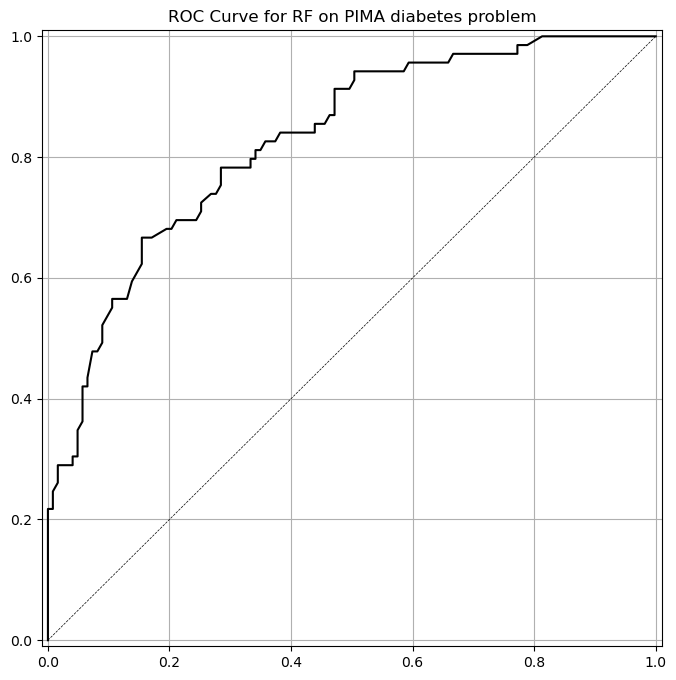

In [39]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.


In [25]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [26]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

In [27]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Let's fit our model for 200 epochs.


In [28]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.


Train on 576 samples, validate on 192 samples
Epoch 1/200


2024-09-21 07:59:21.931611: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-09-21 07:59:21.937013: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2494060000 Hz
2024-09-21 07:59:21.937637: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562e922496f0 executing computations on platform Host. Devices:
2024-09-21 07:59:21.937697: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2024-09-21 07:59:22.013199: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line fl

576/576 [==============================] - 0s 536us/step - loss: 0.6905 - acc: 0.6250 - val_loss: 0.7060 - val_acc: 0.6094
Epoch 2/200
576/576 [==============================] - 0s 119us/step - loss: 0.6889 - acc: 0.6302 - val_loss: 0.7045 - val_acc: 0.6094
Epoch 3/200
576/576 [==============================] - 0s 132us/step - loss: 0.6873 - acc: 0.6302 - val_loss: 0.7031 - val_acc: 0.6094
Epoch 4/200
576/576 [==============================] - 0s 114us/step - loss: 0.6858 - acc: 0.6354 - val_loss: 0.7016 - val_acc: 0.6146
Epoch 5/200
576/576 [==============================] - 0s 109us/step - loss: 0.6843 - acc: 0.6372 - val_loss: 0.7002 - val_acc: 0.6146
Epoch 6/200
576/576 [==============================] - 0s 132us/step - loss: 0.6828 - acc: 0.6372 - val_loss: 0.6989 - val_acc: 0.6198
Epoch 7/200
576/576 [==============================] - 0s 110us/step - loss: 0.6814 - acc: 0.6372 - val_loss: 0.6976 - val_acc: 0.6198
Epoch 8/200
576/576 [==============================] - 0s 108us/ste

In [37]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype(int)

In [31]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [36]:
y_pred_prob_nn_1[:10]

array([[0.37515062],
       [0.44298404],
       [0.3560817 ],
       [0.42497137],
       [0.26298845],
       [0.34853417],
       [0.2127468 ],
       [0.38991505],
       [0.55740845],
       [0.30462348]], dtype=float32)

accuracy is 0.708
roc-auc is 0.771


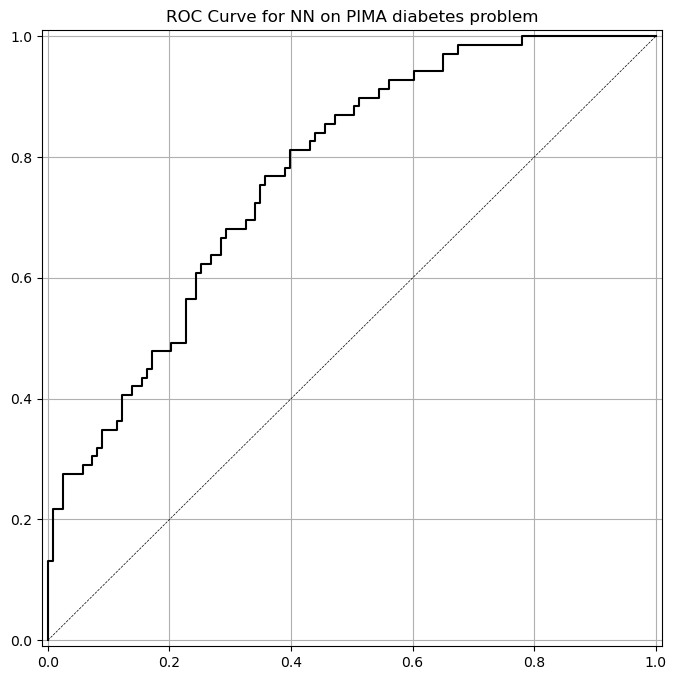

In [40]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.


Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.


In [41]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.


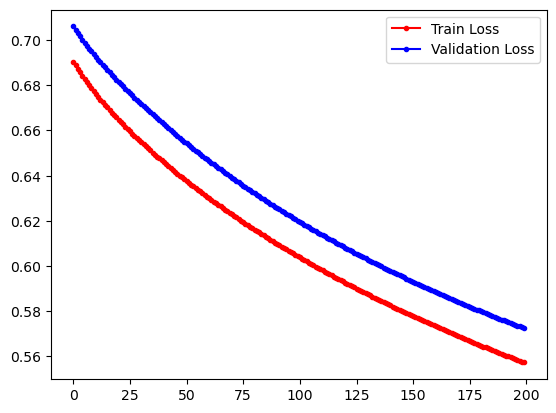

In [42]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.


In [43]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 75us/step - loss: 0.5570 - acc: 0.6753 - val_loss: 0.5721 - val_acc: 0.7083
Epoch 2/1000
576/576 [==============================] - 0s 82us/step - loss: 0.5565 - acc: 0.6788 - val_loss: 0.5718 - val_acc: 0.7135
Epoch 3/1000
576/576 [==============================] - 0s 95us/step - loss: 0.5562 - acc: 0.6788 - val_loss: 0.5714 - val_acc: 0.7135
Epoch 4/1000
576/576 [==============================] - 0s 73us/step - loss: 0.5558 - acc: 0.6788 - val_loss: 0.5710 - val_acc: 0.7135
Epoch 5/1000
576/576 [==============================] - 0s 93us/step - loss: 0.5554 - acc: 0.6806 - val_loss: 0.5706 - val_acc: 0.7135
Epoch 6/1000
576/576 [==============================] - 0s 72us/step - loss: 0.5551 - acc: 0.6806 - val_loss: 0.5703 - val_acc: 0.7135
Epoch 7/1000
576/576 [==============================] - 0s 79us/step - loss: 0.5547 - acc: 0.6806 - val_loss: 0.5699 - val_acc: 0.7135
Epoch 8/1

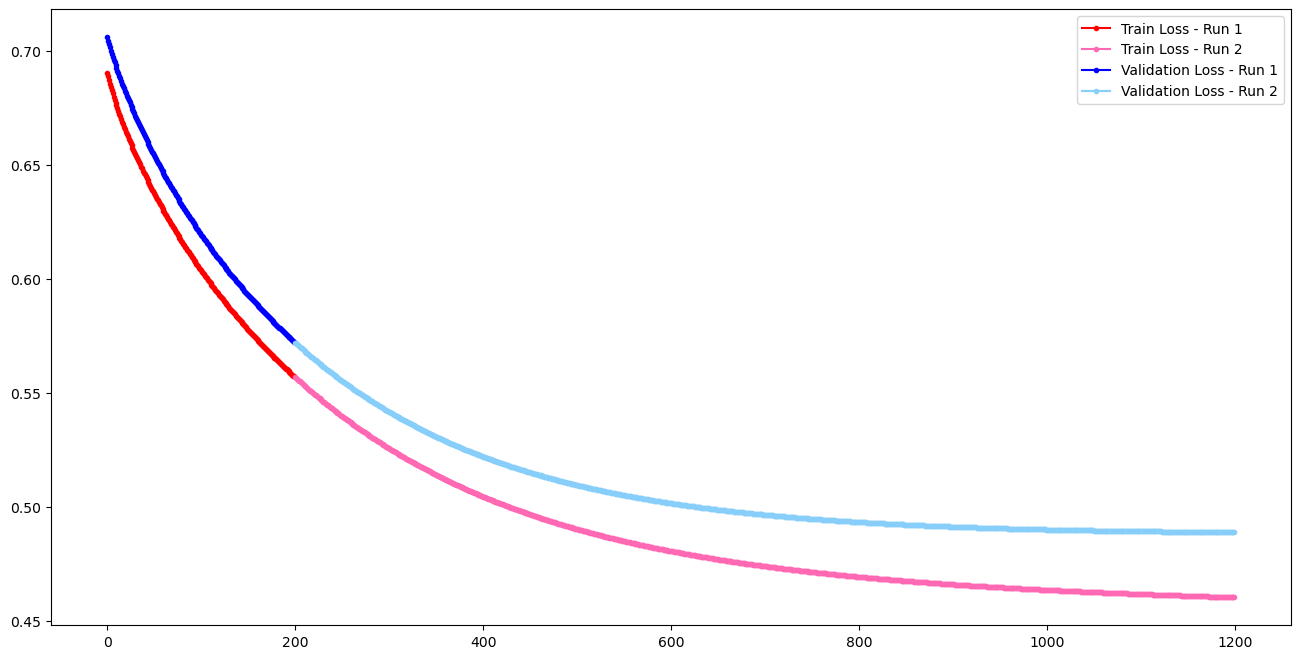

In [44]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?


## Exercise 2
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures


In [45]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Train on 576 samples, validate on 192 samples
Epoch 1/1500
576/576 [==============================] - 0s 453us/step - loss: 0.8748 - acc: 0.6337 - val_loss: 0.9195 - val_acc: 0.6302
Epoch 2/1500
576/576 [==============================] - 0s 121us/step - loss: 0.8548 - acc: 0.6319 - val_loss: 0.8977 - val_acc: 0.6302
Epoch 3/1500
576/576 [==============================] - 0s 106us/step - loss: 0.8374 - acc: 0.6285 - val_loss: 0.8785 - val_acc: 0.6302
Epoch 4/1500
576/576 [==============================] - 0s 136us/step - loss: 0.8218 - acc: 0.6285 - val_loss: 0.8614 - val_acc: 0.6250
Epoch 5/1500
576/576 [==============================] - 0s 132us/step - loss: 0.8081 - acc: 0.6250 - val_loss: 0.8462 - val_acc: 0.6250
Epoch 6/1500
576/576 [==============================] - 0s 130us/step - loss: 0.7959 - acc: 0.6250 - val_loss: 0.8328 - val_acc: 0.6250
Epoch 7/1500
576/576 [==============================] - 0s 83us/step - loss: 0.7850 - acc: 0.6250 - val_loss: 0.8209 - val_acc: 0.6250
Epo

In [46]:
run_hist_2.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Text(0.5, 1.0, 'Accuracy over iterations')

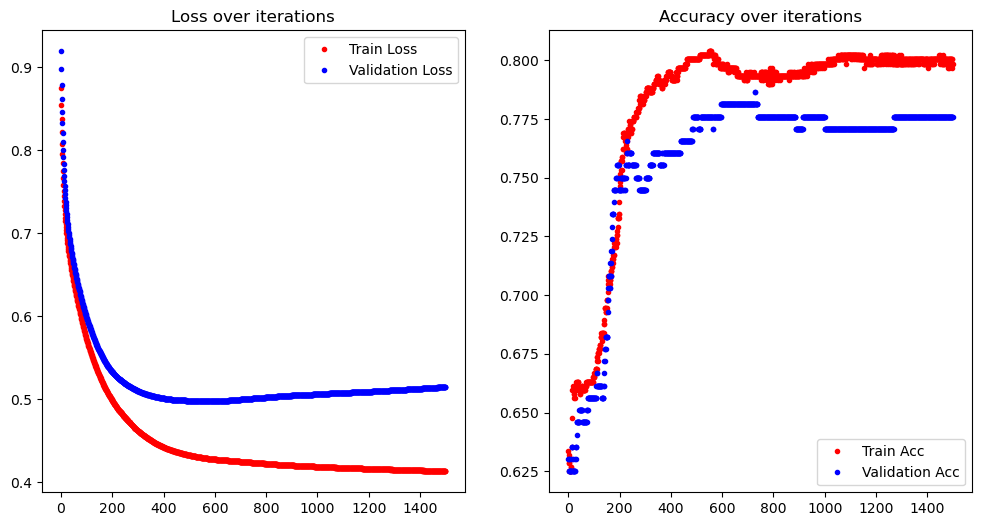

In [47]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["acc"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_acc"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')


accuracy is 0.776
roc-auc is 0.822


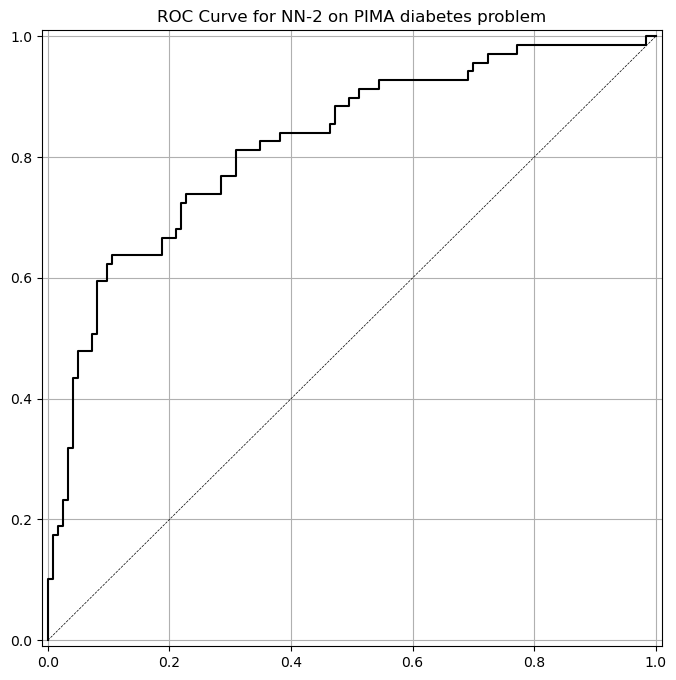

In [48]:
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation
